In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [3]:
torch.manual_seed(33)

In [4]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.models import *

import run
from defaults import FIELD_CONFIGURATIONS

In [5]:
from pytorch_lightning.loggers import LightningLoggerBase # , rank_zero_only
from collections import defaultdict


class PrintLogger(LightningLoggerBase):
    
    def __init__(self):
        super(PrintLogger, self).__init__()
    
    @property
    def name(self):
        return 'PrintLogger'
    
    @property
    def experiment(self):
        return self.name()
    
    @property
    def version(self):
        return '0.0.1'
    
#     @rank_zero_only
    def log_hyperparams(self, params):
        print(f'Hyperparameters:\n{params}')

#     @rank_zero_only
    def log_metrics(self, metrics, step):
        if metrics is not None and len(metrics.keys()) > 0:
            out = ', '.join([f'{key}: {metrics[key]:.4f}' for key in sorted(metrics.keys())])
            print(f'{step}: {out}')

    def save(self):
        # Optional. Any code necessary to save logger data goes here
        pass

#     @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass
    
    
class PlotLogger(LightningLoggerBase):
    
    def __init__(self, metric_groups, plot_grid=None, cmap='Dark2',
                 ax_width=6, ax_height=4, print_final=True):
        super(PlotLogger, self).__init__()
        self.metric_groups = metric_groups
        if plot_grid is None:
            plot_grid = (1, len(self.metric_groups))

        self.plot_grid = plot_grid
        self.metrics = defaultdict(list)
        self.cmap = plt.get_cmap(cmap)
        self.ax_width = ax_width
        self.ax_height = ax_height
        self.print_final = print_final
    
    @property
    def name(self):
        return 'PlotLogger'
    
    @property
    def experiment(self):
        return self.name()
    
    @property
    def version(self):
        return '0.0.1'
    
#     @rank_zero_only
    def log_hyperparams(self, params):
        pass

#     @rank_zero_only
    def log_metrics(self, metrics, step):
        if metrics is not None and len(metrics.keys()) > 0:
            for key in metrics.keys():
                self.metrics[key].append(metrics[key])

    def save(self):
        # Optional. Any code necessary to save logger data goes here
        pass

#     @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here

        if self.print_final:
            out = ', '.join([f'{key}: {self.metrics[key][-1]:.4f}' for key in sorted(self.metrics.keys())])
            print(f'Final values: {out}')
        
        # plot_grid is (n_rows, n_cols)
        plt.figure(figsize=(self.ax_width * self.plot_grid[1], self.ax_height * self.plot_grid[0]))
        
        for i, group_or_name in enumerate(self.metric_groups):
            if isinstance(group_or_name, str):
                group = self.metric_groups[group_or_name]
                name = group_or_name
            else:
                group = group_or_name
                name = None
                
            ax = plt.subplot(*self.plot_grid, i + 1)
            for j, key in enumerate(sorted(group)):
                ax.plot(self.metrics[key], color=self.cmap(j), label=key)
                
            ax.legend(loc='best')
            ax.set_xlabel('Epochs')
            if name is not None:
                ax.set_title(name.title())
            
        plt.show()

In [6]:
X = {}
y = {}
object_generators = {}
positive_indices = {}
negative_indices = {}

for num_objects in (5, 10):
    
    for i, relation in enumerate(run.RELATION_NAMES_TO_CLASSES):
        key = (num_objects, relation)
        
        relation_class = run.RELATION_NAMES_TO_CLASSES[relation]
        object_generator = object_gen.SmartBalancedBatchObjectGenerator(
            num_objects, run.FIELD_CONFIGURATIONS['default'], relation_class)
        object_generators[key] = object_generator
            
        X[key], y[key] = object_generator(100)
        y[key] = y[key].bool()
        
        positive_indices[key] = torch.nonzero(y[key]).squeeze()
        negative_indices[key] = torch.nonzero(~y[key]).squeeze()
                   


(5, 'adjacent')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: Checkpoint directory /home/gd1279/projects/simple-relational-reasoning/notebooks/PrintLogger_PlotLogger/version_0.0.1_0.0.1/checkpoints exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


15: val_acc: 0.5868, val_loss: 0.6833
16: train_acc: 0.5340, train_loss: 0.6903


31: val_acc: 0.7557, val_loss: 0.6265
32: train_acc: 0.6660, train_loss: 0.6643


47: val_acc: 0.8881, val_loss: 0.3982
48: train_acc: 0.8254, train_loss: 0.5349


63: val_acc: 0.9507, val_loss: 0.2213
64: train_acc: 0.9108, train_loss: 0.2996


79: val_acc: 0.9709, val_loss: 0.1053
80: train_acc: 0.9601, train_loss: 0.1550


95: val_acc: 0.9885, val_loss: 0.0557
96: train_acc: 0.9814, train_loss: 0.0785


111: val_acc: 0.9945, val_loss: 0.0321
112: train_acc: 0.9908, train_loss: 0.0437


127: val_acc: 0.9968, val_loss: 0.0207
128: train_acc: 0.9951, train_loss: 0.0262


143: val_acc: 0.9976, val_loss: 0.0144
144: train_acc: 0.9971, train_loss: 0.0171


159: val_acc: 0.9980, val_loss: 0.0108
160: train_acc: 0.9979, train_loss: 0.0120


175: val_acc: 0.9984, val_loss: 0.0084
176: train_acc: 0.9989, train_loss: 0.0087


191: val_acc: 0.9989, val_loss: 0.0068
192: train_acc: 0.9993, train_loss: 0.0065


207: val_acc: 0.9990, val_loss: 0.0056
208: train_acc: 0.9995, train_loss: 0.0049


223: val_acc: 0.9991, val_loss: 0.0049
224: train_acc: 0.9998, train_loss: 0.0039


239: val_acc: 0.9992, val_loss: 0.0042
240: train_acc: 0.9999, train_loss: 0.0031


255: val_acc: 0.9993, val_loss: 0.0036
256: train_acc: 0.9999, train_loss: 0.0025


271: val_acc: 0.9996, val_loss: 0.0031
272: train_acc: 0.9999, train_loss: 0.0021


287: val_acc: 0.9996, val_loss: 0.0028
288: train_acc: 1.0000, train_loss: 0.0017


303: val_acc: 0.9996, val_loss: 0.0026
304: train_acc: 1.0000, train_loss: 0.0014


319: val_acc: 0.9998, val_loss: 0.0024
320: train_acc: 1.0000, train_loss: 0.0012


335: val_acc: 0.9998, val_loss: 0.0022
336: train_acc: 1.0000, train_loss: 0.0010


351: val_acc: 0.9998, val_loss: 0.0021
352: train_acc: 1.0000, train_loss: 0.0009


367: val_acc: 0.9998, val_loss: 0.0020
368: train_acc: 1.0000, train_loss: 0.0008


383: val_acc: 0.9998, val_loss: 0.0019
384: train_acc: 1.0000, train_loss: 0.0007


399: val_acc: 0.9998, val_loss: 0.0018
400: train_acc: 1.0000, train_loss: 0.0006


415: val_acc: 0.9998, val_loss: 0.0017
416: train_acc: 1.0000, train_loss: 0.0005


431: val_acc: 0.9997, val_loss: 0.0017
432: train_acc: 1.0000, train_loss: 0.0005


447: val_acc: 0.9997, val_loss: 0.0017
448: train_acc: 1.0000, train_loss: 0.0004


463: val_acc: 0.9997, val_loss: 0.0017
464: train_acc: 1.0000, train_loss: 0.0004


479: val_acc: 0.9996, val_loss: 0.0017
480: train_acc: 1.0000, train_loss: 0.0004


495: val_acc: 0.9995, val_loss: 0.0017
496: train_acc: 1.0000, train_loss: 0.0003


511: val_acc: 0.9995, val_loss: 0.0017
512: train_acc: 1.0000, train_loss: 0.0003


527: val_acc: 0.9994, val_loss: 0.0017
528: train_acc: 1.0000, train_loss: 0.0003


543: val_acc: 0.9994, val_loss: 0.0017
544: train_acc: 1.0000, train_loss: 0.0003


559: val_acc: 0.9993, val_loss: 0.0017

Final values: train_acc: 1.0000, train_loss: 0.0003, val_acc: 0.9993, val_loss: 0.0017


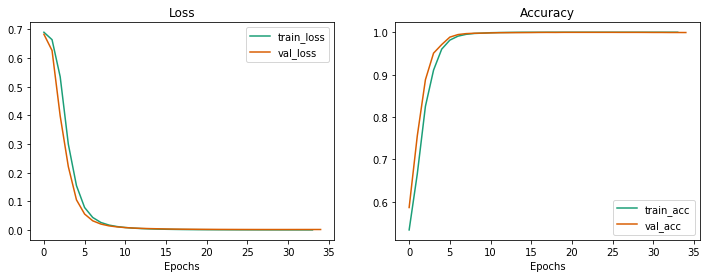

(5, 'above')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5846, val_loss: 0.6757
16: train_acc: 0.5491, train_loss: 0.6860


31: val_acc: 0.5951, val_loss: 0.6647
32: train_acc: 0.5889, train_loss: 0.6701


47: val_acc: 0.6075, val_loss: 0.6554
48: train_acc: 0.5992, train_loss: 0.6593


63: val_acc: 0.6277, val_loss: 0.6432
64: train_acc: 0.6214, train_loss: 0.6483


79: val_acc: 0.6847, val_loss: 0.6084
80: train_acc: 0.6613, train_loss: 0.6266


95: val_acc: 0.7961, val_loss: 0.4975
96: train_acc: 0.7451, train_loss: 0.5579


111: val_acc: 0.8687, val_loss: 0.3495
112: train_acc: 0.8355, train_loss: 0.4219


127: val_acc: 0.9093, val_loss: 0.2656
128: train_acc: 0.8849, train_loss: 0.3115


143: val_acc: 0.9347, val_loss: 0.2130
144: train_acc: 0.9171, train_loss: 0.2386


159: val_acc: 0.9457, val_loss: 0.1775
160: train_acc: 0.9373, train_loss: 0.1915


175: val_acc: 0.9545, val_loss: 0.1529
176: train_acc: 0.9504, train_loss: 0.1596


191: val_acc: 0.9588, val_loss: 0.1364
192: train_acc: 0.9586, train_loss: 0.1376


207: val_acc: 0.9633, val_loss: 0.1244
208: train_acc: 0.9641, train_loss: 0.1215


223: val_acc: 0.9655, val_loss: 0.1165
224: train_acc: 0.9688, train_loss: 0.1090


239: val_acc: 0.9667, val_loss: 0.1110
240: train_acc: 0.9720, train_loss: 0.0991


255: val_acc: 0.9680, val_loss: 0.1060
256: train_acc: 0.9742, train_loss: 0.0911


271: val_acc: 0.9700, val_loss: 0.0998
272: train_acc: 0.9767, train_loss: 0.0844


287: val_acc: 0.9713, val_loss: 0.0960
288: train_acc: 0.9796, train_loss: 0.0785


303: val_acc: 0.9713, val_loss: 0.0950
304: train_acc: 0.9815, train_loss: 0.0740


319: val_acc: 0.9720, val_loss: 0.0923
320: train_acc: 0.9833, train_loss: 0.0696


335: val_acc: 0.9744, val_loss: 0.0879
336: train_acc: 0.9839, train_loss: 0.0657


351: val_acc: 0.9741, val_loss: 0.0866
352: train_acc: 0.9846, train_loss: 0.0629


367: val_acc: 0.9722, val_loss: 0.0882
368: train_acc: 0.9855, train_loss: 0.0601


383: val_acc: 0.9753, val_loss: 0.0832
384: train_acc: 0.9869, train_loss: 0.0568


399: val_acc: 0.9758, val_loss: 0.0815
400: train_acc: 0.9870, train_loss: 0.0544


415: val_acc: 0.9760, val_loss: 0.0807
416: train_acc: 0.9877, train_loss: 0.0522


431: val_acc: 0.9760, val_loss: 0.0784
432: train_acc: 0.9888, train_loss: 0.0494


447: val_acc: 0.9775, val_loss: 0.0771
448: train_acc: 0.9888, train_loss: 0.0483


463: val_acc: 0.9767, val_loss: 0.0791
464: train_acc: 0.9886, train_loss: 0.0474


479: val_acc: 0.9722, val_loss: 0.0877
480: train_acc: 0.9860, train_loss: 0.0504


495: val_acc: 0.9557, val_loss: 0.1411
496: train_acc: 0.9799, train_loss: 0.0609


511: val_acc: 0.9547, val_loss: 0.1176
512: train_acc: 0.9688, train_loss: 0.0862


527: val_acc: 0.9734, val_loss: 0.0799

Final values: train_acc: 0.9688, train_loss: 0.0862, val_acc: 0.9734, val_loss: 0.0799


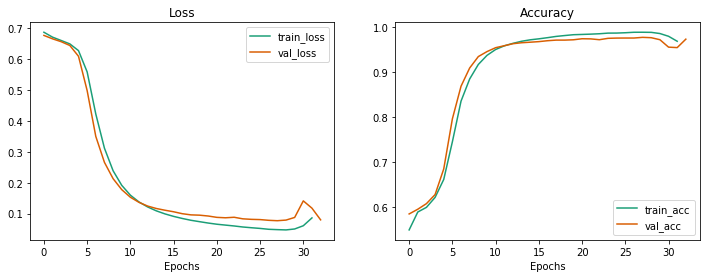

(5, 'count')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5530, val_loss: 0.6915
16: train_acc: 0.5220, train_loss: 0.6926


31: val_acc: 0.6340, val_loss: 0.6777
32: train_acc: 0.5967, train_loss: 0.6865


47: val_acc: 0.7895, val_loss: 0.5753
48: train_acc: 0.7272, train_loss: 0.6405


63: val_acc: 0.8686, val_loss: 0.3391
64: train_acc: 0.8462, train_loss: 0.4546


79: val_acc: 0.8868, val_loss: 0.2600
80: train_acc: 0.8825, train_loss: 0.2841


95: val_acc: 0.9117, val_loss: 0.2172
96: train_acc: 0.9045, train_loss: 0.2278


111: val_acc: 0.9168, val_loss: 0.2000
112: train_acc: 0.9247, train_loss: 0.1921


127: val_acc: 0.9268, val_loss: 0.1803
128: train_acc: 0.9321, train_loss: 0.1706


143: val_acc: 0.9321, val_loss: 0.1669
144: train_acc: 0.9400, train_loss: 0.1548


159: val_acc: 0.9354, val_loss: 0.1577
160: train_acc: 0.9457, train_loss: 0.1408


175: val_acc: 0.9398, val_loss: 0.1491
176: train_acc: 0.9519, train_loss: 0.1279


191: val_acc: 0.9448, val_loss: 0.1372
192: train_acc: 0.9574, train_loss: 0.1153


207: val_acc: 0.9512, val_loss: 0.1245
208: train_acc: 0.9631, train_loss: 0.1029


223: val_acc: 0.9553, val_loss: 0.1139
224: train_acc: 0.9670, train_loss: 0.0910


239: val_acc: 0.9608, val_loss: 0.1036
240: train_acc: 0.9717, train_loss: 0.0798


255: val_acc: 0.9665, val_loss: 0.0936
256: train_acc: 0.9759, train_loss: 0.0690


271: val_acc: 0.9702, val_loss: 0.0830
272: train_acc: 0.9795, train_loss: 0.0594


287: val_acc: 0.9742, val_loss: 0.0725
288: train_acc: 0.9841, train_loss: 0.0504


303: val_acc: 0.9766, val_loss: 0.0648
304: train_acc: 0.9868, train_loss: 0.0428


319: val_acc: 0.9794, val_loss: 0.0580
320: train_acc: 0.9895, train_loss: 0.0366


335: val_acc: 0.9810, val_loss: 0.0525
336: train_acc: 0.9911, train_loss: 0.0313


351: val_acc: 0.9825, val_loss: 0.0482
352: train_acc: 0.9924, train_loss: 0.0270


367: val_acc: 0.9836, val_loss: 0.0452
368: train_acc: 0.9933, train_loss: 0.0236


383: val_acc: 0.9845, val_loss: 0.0428
384: train_acc: 0.9945, train_loss: 0.0211


399: val_acc: 0.9849, val_loss: 0.0418
400: train_acc: 0.9945, train_loss: 0.0206


415: val_acc: 0.9808, val_loss: 0.0530
416: train_acc: 0.9918, train_loss: 0.0248


431: val_acc: 0.9655, val_loss: 0.0941
432: train_acc: 0.9759, train_loss: 0.0563


447: val_acc: 0.9694, val_loss: 0.0841
448: train_acc: 0.9708, train_loss: 0.0719


463: val_acc: 0.9890, val_loss: 0.0301
464: train_acc: 0.9915, train_loss: 0.0240


479: val_acc: 0.9888, val_loss: 0.0300
480: train_acc: 0.9965, train_loss: 0.0121


495: val_acc: 0.9893, val_loss: 0.0290
496: train_acc: 0.9976, train_loss: 0.0111


511: val_acc: 0.9895, val_loss: 0.0280
512: train_acc: 0.9977, train_loss: 0.0109


527: val_acc: 0.9903, val_loss: 0.0269
528: train_acc: 0.9979, train_loss: 0.0104


543: val_acc: 0.9905, val_loss: 0.0260
544: train_acc: 0.9984, train_loss: 0.0099


559: val_acc: 0.9905, val_loss: 0.0256
560: train_acc: 0.9982, train_loss: 0.0094


575: val_acc: 0.9903, val_loss: 0.0257
576: train_acc: 0.9982, train_loss: 0.0089


591: val_acc: 0.9905, val_loss: 0.0266
592: train_acc: 0.9981, train_loss: 0.0084


607: val_acc: 0.9900, val_loss: 0.0279
608: train_acc: 0.9982, train_loss: 0.0080


623: val_acc: 0.9900, val_loss: 0.0294
624: train_acc: 0.9982, train_loss: 0.0076


639: val_acc: 0.9897, val_loss: 0.0304

Final values: train_acc: 0.9982, train_loss: 0.0076, val_acc: 0.9897, val_loss: 0.0304


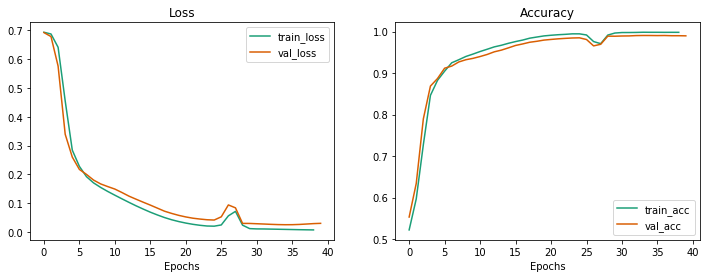

(5, 'between')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5672, val_loss: 0.6771
16: train_acc: 0.5435, train_loss: 0.6901


31: val_acc: 0.6348, val_loss: 0.6231
32: train_acc: 0.5931, train_loss: 0.6588


47: val_acc: 0.9097, val_loss: 0.3818
48: train_acc: 0.7894, train_loss: 0.5389


63: val_acc: 0.9359, val_loss: 0.1536
64: train_acc: 0.9291, train_loss: 0.2431


79: val_acc: 0.9684, val_loss: 0.0901
80: train_acc: 0.9521, train_loss: 0.1296


95: val_acc: 0.9774, val_loss: 0.0697
96: train_acc: 0.9695, train_loss: 0.0891


111: val_acc: 0.9849, val_loss: 0.0545
112: train_acc: 0.9800, train_loss: 0.0691


127: val_acc: 0.9896, val_loss: 0.0452
128: train_acc: 0.9852, train_loss: 0.0551


143: val_acc: 0.9919, val_loss: 0.0380
144: train_acc: 0.9892, train_loss: 0.0457


159: val_acc: 0.9932, val_loss: 0.0320
160: train_acc: 0.9911, train_loss: 0.0379


175: val_acc: 0.9946, val_loss: 0.0274
176: train_acc: 0.9930, train_loss: 0.0317


191: val_acc: 0.9954, val_loss: 0.0238
192: train_acc: 0.9940, train_loss: 0.0265


207: val_acc: 0.9958, val_loss: 0.0210
208: train_acc: 0.9949, train_loss: 0.0225


223: val_acc: 0.9963, val_loss: 0.0187
224: train_acc: 0.9955, train_loss: 0.0192


239: val_acc: 0.9966, val_loss: 0.0169
240: train_acc: 0.9959, train_loss: 0.0166


255: val_acc: 0.9975, val_loss: 0.0155
256: train_acc: 0.9966, train_loss: 0.0144


271: val_acc: 0.9975, val_loss: 0.0143
272: train_acc: 0.9971, train_loss: 0.0126


287: val_acc: 0.9976, val_loss: 0.0134
288: train_acc: 0.9976, train_loss: 0.0112


303: val_acc: 0.9977, val_loss: 0.0126
304: train_acc: 0.9979, train_loss: 0.0100


319: val_acc: 0.9978, val_loss: 0.0119
320: train_acc: 0.9978, train_loss: 0.0090


335: val_acc: 0.9978, val_loss: 0.0111
336: train_acc: 0.9980, train_loss: 0.0083


351: val_acc: 0.9979, val_loss: 0.0104
352: train_acc: 0.9983, train_loss: 0.0078


367: val_acc: 0.9980, val_loss: 0.0096
368: train_acc: 0.9984, train_loss: 0.0075


383: val_acc: 0.9981, val_loss: 0.0090
384: train_acc: 0.9984, train_loss: 0.0073


399: val_acc: 0.9981, val_loss: 0.0086
400: train_acc: 0.9984, train_loss: 0.0073


415: val_acc: 0.9979, val_loss: 0.0090
416: train_acc: 0.9982, train_loss: 0.0075


431: val_acc: 0.9974, val_loss: 0.0103
432: train_acc: 0.9980, train_loss: 0.0081


447: val_acc: 0.9969, val_loss: 0.0119
448: train_acc: 0.9975, train_loss: 0.0095


463: val_acc: 0.9960, val_loss: 0.0161
464: train_acc: 0.9976, train_loss: 0.0098


479: val_acc: 0.9966, val_loss: 0.0135

Final values: train_acc: 0.9976, train_loss: 0.0098, val_acc: 0.9966, val_loss: 0.0135


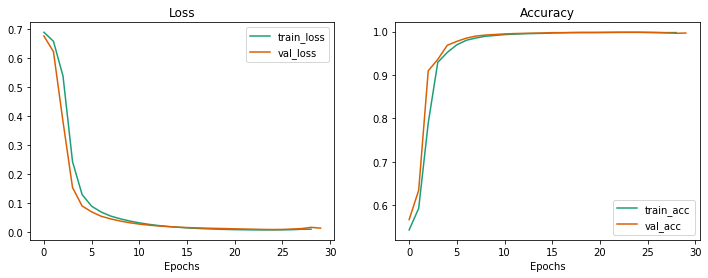

(10, 'adjacent')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5912, val_loss: 0.6852
16: train_acc: 0.5387, train_loss: 0.6905


31: val_acc: 0.6100, val_loss: 0.6517
32: train_acc: 0.6574, train_loss: 0.6711


47: val_acc: 0.8447, val_loss: 0.5063
48: train_acc: 0.7679, train_loss: 0.5908


63: val_acc: 0.8875, val_loss: 0.3609
64: train_acc: 0.8270, train_loss: 0.4442


79: val_acc: 0.9213, val_loss: 0.2419
80: train_acc: 0.9006, train_loss: 0.2990


95: val_acc: 0.9200, val_loss: 0.2155
96: train_acc: 0.9175, train_loss: 0.2223


111: val_acc: 0.9516, val_loss: 0.1417
112: train_acc: 0.9376, train_loss: 0.1762


127: val_acc: 0.9632, val_loss: 0.1148
128: train_acc: 0.9573, train_loss: 0.1282


143: val_acc: 0.9700, val_loss: 0.0951
144: train_acc: 0.9672, train_loss: 0.1031


159: val_acc: 0.9743, val_loss: 0.0793
160: train_acc: 0.9732, train_loss: 0.0851


175: val_acc: 0.9781, val_loss: 0.0663
176: train_acc: 0.9779, train_loss: 0.0704


191: val_acc: 0.9821, val_loss: 0.0555
192: train_acc: 0.9819, train_loss: 0.0583


207: val_acc: 0.9848, val_loss: 0.0468
208: train_acc: 0.9854, train_loss: 0.0482


223: val_acc: 0.9872, val_loss: 0.0396
224: train_acc: 0.9886, train_loss: 0.0398


239: val_acc: 0.9892, val_loss: 0.0339
240: train_acc: 0.9910, train_loss: 0.0335


255: val_acc: 0.9908, val_loss: 0.0291
256: train_acc: 0.9919, train_loss: 0.0285


271: val_acc: 0.9926, val_loss: 0.0257
272: train_acc: 0.9932, train_loss: 0.0246


287: val_acc: 0.9937, val_loss: 0.0250
288: train_acc: 0.9937, train_loss: 0.0216


303: val_acc: 0.9944, val_loss: 0.0223
304: train_acc: 0.9950, train_loss: 0.0187


319: val_acc: 0.9942, val_loss: 0.0175
320: train_acc: 0.9958, train_loss: 0.0161


335: val_acc: 0.9934, val_loss: 0.0180
336: train_acc: 0.9973, train_loss: 0.0127


351: val_acc: 0.9951, val_loss: 0.0147
352: train_acc: 0.9979, train_loss: 0.0102


367: val_acc: 0.9949, val_loss: 0.0142
368: train_acc: 0.9982, train_loss: 0.0088


383: val_acc: 0.9952, val_loss: 0.0131
384: train_acc: 0.9986, train_loss: 0.0077


399: val_acc: 0.9953, val_loss: 0.0125
400: train_acc: 0.9990, train_loss: 0.0067


415: val_acc: 0.9957, val_loss: 0.0119
416: train_acc: 0.9990, train_loss: 0.0059


431: val_acc: 0.9957, val_loss: 0.0114
432: train_acc: 0.9992, train_loss: 0.0052


447: val_acc: 0.9958, val_loss: 0.0110
448: train_acc: 0.9995, train_loss: 0.0046


463: val_acc: 0.9957, val_loss: 0.0109
464: train_acc: 0.9996, train_loss: 0.0042


479: val_acc: 0.9956, val_loss: 0.0109
480: train_acc: 0.9997, train_loss: 0.0038


495: val_acc: 0.9955, val_loss: 0.0110
496: train_acc: 0.9999, train_loss: 0.0035


511: val_acc: 0.9954, val_loss: 0.0111
512: train_acc: 0.9999, train_loss: 0.0033


527: val_acc: 0.9955, val_loss: 0.0113
528: train_acc: 0.9999, train_loss: 0.0032


543: val_acc: 0.9955, val_loss: 0.0112
544: train_acc: 0.9999, train_loss: 0.0031


559: val_acc: 0.9958, val_loss: 0.0110

Final values: train_acc: 0.9999, train_loss: 0.0031, val_acc: 0.9958, val_loss: 0.0110


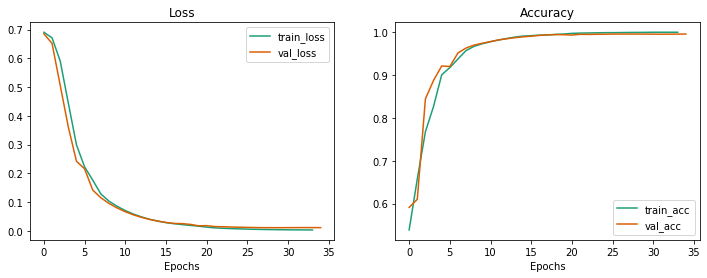

(10, 'above')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5348, val_loss: 0.6905
16: train_acc: 0.5061, train_loss: 0.6973


31: val_acc: 0.5565, val_loss: 0.6843
32: train_acc: 0.5456, train_loss: 0.6873


47: val_acc: 0.5876, val_loss: 0.6730
48: train_acc: 0.5757, train_loss: 0.6773


63: val_acc: 0.5985, val_loss: 0.6650
64: train_acc: 0.5971, train_loss: 0.6669


79: val_acc: 0.6107, val_loss: 0.6551
80: train_acc: 0.6072, train_loss: 0.6571


95: val_acc: 0.6314, val_loss: 0.6400
96: train_acc: 0.6227, train_loss: 0.6446


111: val_acc: 0.6806, val_loss: 0.6081
112: train_acc: 0.6555, train_loss: 0.6219


127: val_acc: 0.7754, val_loss: 0.5171
128: train_acc: 0.7211, train_loss: 0.5671


143: val_acc: 0.8412, val_loss: 0.3900
144: train_acc: 0.8057, train_loss: 0.4560


159: val_acc: 0.8790, val_loss: 0.3099
160: train_acc: 0.8571, train_loss: 0.3482


175: val_acc: 0.8964, val_loss: 0.2604
176: train_acc: 0.8862, train_loss: 0.2788


191: val_acc: 0.9144, val_loss: 0.2286
192: train_acc: 0.9070, train_loss: 0.2362


207: val_acc: 0.9256, val_loss: 0.2049
208: train_acc: 0.9225, train_loss: 0.2052


223: val_acc: 0.9335, val_loss: 0.1869
224: train_acc: 0.9346, train_loss: 0.1821


239: val_acc: 0.9404, val_loss: 0.1739
240: train_acc: 0.9438, train_loss: 0.1629


255: val_acc: 0.9437, val_loss: 0.1667
256: train_acc: 0.9507, train_loss: 0.1478


271: val_acc: 0.9463, val_loss: 0.1616
272: train_acc: 0.9561, train_loss: 0.1360


287: val_acc: 0.9531, val_loss: 0.1447
288: train_acc: 0.9589, train_loss: 0.1273


303: val_acc: 0.9504, val_loss: 0.1397
304: train_acc: 0.9625, train_loss: 0.1207


319: val_acc: 0.9565, val_loss: 0.1330
320: train_acc: 0.9670, train_loss: 0.1107


335: val_acc: 0.9570, val_loss: 0.1273
336: train_acc: 0.9698, train_loss: 0.1037


351: val_acc: 0.9583, val_loss: 0.1239
352: train_acc: 0.9714, train_loss: 0.0990


367: val_acc: 0.9602, val_loss: 0.1204
368: train_acc: 0.9736, train_loss: 0.0936


383: val_acc: 0.9613, val_loss: 0.1171
384: train_acc: 0.9758, train_loss: 0.0886


399: val_acc: 0.9625, val_loss: 0.1127
400: train_acc: 0.9769, train_loss: 0.0837


415: val_acc: 0.9637, val_loss: 0.1085
416: train_acc: 0.9786, train_loss: 0.0788


431: val_acc: 0.9653, val_loss: 0.1046
432: train_acc: 0.9810, train_loss: 0.0738


447: val_acc: 0.9673, val_loss: 0.1014
448: train_acc: 0.9822, train_loss: 0.0693


463: val_acc: 0.9675, val_loss: 0.0987
464: train_acc: 0.9833, train_loss: 0.0655


479: val_acc: 0.9692, val_loss: 0.0967
480: train_acc: 0.9846, train_loss: 0.0621


495: val_acc: 0.9702, val_loss: 0.0947
496: train_acc: 0.9858, train_loss: 0.0589


511: val_acc: 0.9716, val_loss: 0.0925
512: train_acc: 0.9871, train_loss: 0.0559


527: val_acc: 0.9724, val_loss: 0.0909
528: train_acc: 0.9882, train_loss: 0.0530


543: val_acc: 0.9723, val_loss: 0.0906
544: train_acc: 0.9893, train_loss: 0.0506


559: val_acc: 0.9727, val_loss: 0.0898
560: train_acc: 0.9897, train_loss: 0.0483


575: val_acc: 0.9730, val_loss: 0.0880
576: train_acc: 0.9901, train_loss: 0.0465


591: val_acc: 0.9747, val_loss: 0.0848
592: train_acc: 0.9901, train_loss: 0.0456


607: val_acc: 0.9710, val_loss: 0.0871
608: train_acc: 0.9885, train_loss: 0.0471


623: val_acc: 0.9509, val_loss: 0.1365
624: train_acc: 0.9819, train_loss: 0.0560


639: val_acc: 0.9655, val_loss: 0.0979
640: train_acc: 0.9749, train_loss: 0.0723


655: val_acc: 0.9676, val_loss: 0.0950
656: train_acc: 0.9796, train_loss: 0.0606


671: val_acc: 0.9769, val_loss: 0.0804
672: train_acc: 0.9802, train_loss: 0.0596


687: val_acc: 0.9672, val_loss: 0.1023
688: train_acc: 0.9811, train_loss: 0.0573


703: val_acc: 0.9769, val_loss: 0.0787
704: train_acc: 0.9903, train_loss: 0.0406


719: val_acc: 0.9751, val_loss: 0.0822
720: train_acc: 0.9933, train_loss: 0.0366


735: val_acc: 0.9761, val_loss: 0.0801
736: train_acc: 0.9939, train_loss: 0.0343


751: val_acc: 0.9756, val_loss: 0.0816
752: train_acc: 0.9945, train_loss: 0.0334


767: val_acc: 0.9753, val_loss: 0.0822
768: train_acc: 0.9946, train_loss: 0.0325


783: val_acc: 0.9761, val_loss: 0.0815

Final values: train_acc: 0.9946, train_loss: 0.0325, val_acc: 0.9761, val_loss: 0.0815


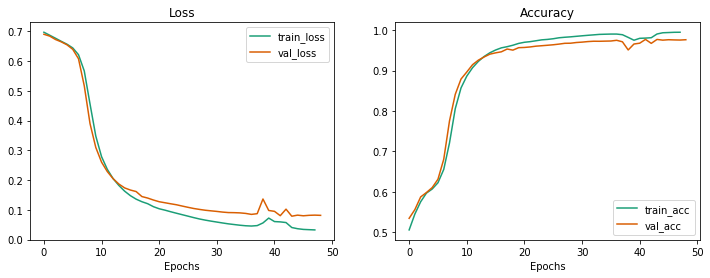

(10, 'count')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5002, val_loss: 0.6930
16: train_acc: 0.5086, train_loss: 0.6943


31: val_acc: 0.5736, val_loss: 0.6893
32: train_acc: 0.5197, train_loss: 0.6909


47: val_acc: 0.6716, val_loss: 0.6819
48: train_acc: 0.5427, train_loss: 0.6867


63: val_acc: 0.7835, val_loss: 0.6539
64: train_acc: 0.6478, train_loss: 0.6709


79: val_acc: 0.7910, val_loss: 0.5304
80: train_acc: 0.7267, train_loss: 0.6066


95: val_acc: 0.8651, val_loss: 0.3106
96: train_acc: 0.8354, train_loss: 0.4161


111: val_acc: 0.8819, val_loss: 0.2643
112: train_acc: 0.8704, train_loss: 0.2865


127: val_acc: 0.8827, val_loss: 0.2608
128: train_acc: 0.8889, train_loss: 0.2560


143: val_acc: 0.8941, val_loss: 0.2373
144: train_acc: 0.9002, train_loss: 0.2272


159: val_acc: 0.8997, val_loss: 0.2247
160: train_acc: 0.9066, train_loss: 0.2130


175: val_acc: 0.9039, val_loss: 0.2144
176: train_acc: 0.9112, train_loss: 0.2005


191: val_acc: 0.9020, val_loss: 0.2192
192: train_acc: 0.9164, train_loss: 0.1902


207: val_acc: 0.9023, val_loss: 0.2213
208: train_acc: 0.9197, train_loss: 0.1804


223: val_acc: 0.9075, val_loss: 0.2082
224: train_acc: 0.9261, train_loss: 0.1690


239: val_acc: 0.9092, val_loss: 0.2036
240: train_acc: 0.9332, train_loss: 0.1577


255: val_acc: 0.9084, val_loss: 0.2032
256: train_acc: 0.9378, train_loss: 0.1485


271: val_acc: 0.9113, val_loss: 0.1971
272: train_acc: 0.9415, train_loss: 0.1402


287: val_acc: 0.9121, val_loss: 0.1944
288: train_acc: 0.9448, train_loss: 0.1327


303: val_acc: 0.9144, val_loss: 0.1909
304: train_acc: 0.9485, train_loss: 0.1263


319: val_acc: 0.9180, val_loss: 0.1830
320: train_acc: 0.9518, train_loss: 0.1191


335: val_acc: 0.9226, val_loss: 0.1738
336: train_acc: 0.9556, train_loss: 0.1118


351: val_acc: 0.9257, val_loss: 0.1659
352: train_acc: 0.9588, train_loss: 0.1054


367: val_acc: 0.9296, val_loss: 0.1563
368: train_acc: 0.9604, train_loss: 0.1000


383: val_acc: 0.9352, val_loss: 0.1452
384: train_acc: 0.9630, train_loss: 0.0949


399: val_acc: 0.9395, val_loss: 0.1367
400: train_acc: 0.9651, train_loss: 0.0900


415: val_acc: 0.9423, val_loss: 0.1308
416: train_acc: 0.9676, train_loss: 0.0853


431: val_acc: 0.9445, val_loss: 0.1270
432: train_acc: 0.9697, train_loss: 0.0809


447: val_acc: 0.9464, val_loss: 0.1228
448: train_acc: 0.9720, train_loss: 0.0768


463: val_acc: 0.9474, val_loss: 0.1204
464: train_acc: 0.9734, train_loss: 0.0733


479: val_acc: 0.9493, val_loss: 0.1173
480: train_acc: 0.9755, train_loss: 0.0700


495: val_acc: 0.9504, val_loss: 0.1151
496: train_acc: 0.9759, train_loss: 0.0669


511: val_acc: 0.9517, val_loss: 0.1118
512: train_acc: 0.9771, train_loss: 0.0642


527: val_acc: 0.9552, val_loss: 0.1053
528: train_acc: 0.9785, train_loss: 0.0613


543: val_acc: 0.9589, val_loss: 0.0960
544: train_acc: 0.9803, train_loss: 0.0578


559: val_acc: 0.9626, val_loss: 0.0885
560: train_acc: 0.9813, train_loss: 0.0551


575: val_acc: 0.9595, val_loss: 0.0972
576: train_acc: 0.9761, train_loss: 0.0603


591: val_acc: 0.9471, val_loss: 0.1244
592: train_acc: 0.9724, train_loss: 0.0661


607: val_acc: 0.9556, val_loss: 0.1043
608: train_acc: 0.9763, train_loss: 0.0606


623: val_acc: 0.9324, val_loss: 0.1644
624: train_acc: 0.9747, train_loss: 0.0630


639: val_acc: 0.9498, val_loss: 0.1215

Final values: train_acc: 0.9747, train_loss: 0.0630, val_acc: 0.9498, val_loss: 0.1215


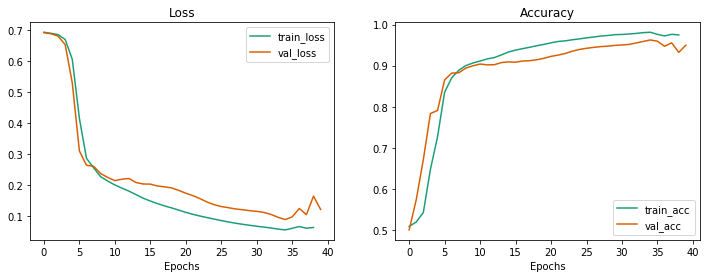

(10, 'between')


INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name              | Type       | Params
---------------------------------------------
0  | conv_module       | Sequential | 3 K   
1  | conv_module.0     | Conv2d     | 880   
2  | conv_module.1     | ReLU       | 0     
3  | conv_module.2     | MaxPool2d  | 0     
4  | conv_module.3     | Conv2d     | 2 K   
5  | conv_module.4     | ReLU       | 0     
6  | conv_module.5     | MaxPool2d  | 0     
7  | mlp_module        | Sequential | 9 K   
8  | mlp_module.0      | Linear     | 8 K   
9  | mlp_module.1      | ReLU       | 0     
10 | mlp_module.2      | Linear     | 1 K   
11 | mlp_module.3      | ReLU       | 0     
12 | output_layer      | Linear     | 66    
13 | output_activation | Identity   | 0     


Hyperparameters:
None


15: val_acc: 0.5998, val_loss: 0.6823
16: train_acc: 0.5464, train_loss: 0.6889


31: val_acc: 0.7305, val_loss: 0.6391
32: train_acc: 0.6173, train_loss: 0.6689


47: val_acc: 0.8077, val_loss: 0.4459
48: train_acc: 0.7688, train_loss: 0.5564


63: val_acc: 0.8467, val_loss: 0.3542
64: train_acc: 0.8253, train_loss: 0.3942


79: val_acc: 0.8788, val_loss: 0.2989
80: train_acc: 0.8647, train_loss: 0.3204


95: val_acc: 0.9000, val_loss: 0.2616
96: train_acc: 0.8922, train_loss: 0.2708


111: val_acc: 0.9183, val_loss: 0.2196
112: train_acc: 0.9127, train_loss: 0.2279


127: val_acc: 0.9333, val_loss: 0.1839
128: train_acc: 0.9318, train_loss: 0.1885


143: val_acc: 0.9441, val_loss: 0.1555
144: train_acc: 0.9478, train_loss: 0.1553


159: val_acc: 0.9539, val_loss: 0.1320
160: train_acc: 0.9584, train_loss: 0.1285


175: val_acc: 0.9620, val_loss: 0.1143
176: train_acc: 0.9667, train_loss: 0.1076


191: val_acc: 0.9683, val_loss: 0.1014
192: train_acc: 0.9721, train_loss: 0.0925


207: val_acc: 0.9718, val_loss: 0.0911
208: train_acc: 0.9760, train_loss: 0.0814


223: val_acc: 0.9719, val_loss: 0.0855
224: train_acc: 0.9789, train_loss: 0.0741


239: val_acc: 0.9684, val_loss: 0.0884
240: train_acc: 0.9783, train_loss: 0.0751


255: val_acc: 0.9482, val_loss: 0.1306
256: train_acc: 0.9742, train_loss: 0.0836


271: val_acc: 0.9800, val_loss: 0.0688
272: train_acc: 0.9780, train_loss: 0.0740


287: val_acc: 0.9828, val_loss: 0.0655
288: train_acc: 0.9868, train_loss: 0.0541


303: val_acc: 0.9834, val_loss: 0.0628
304: train_acc: 0.9882, train_loss: 0.0501


319: val_acc: 0.9834, val_loss: 0.0604
320: train_acc: 0.9891, train_loss: 0.0471


335: val_acc: 0.9839, val_loss: 0.0584
336: train_acc: 0.9898, train_loss: 0.0444


351: val_acc: 0.9846, val_loss: 0.0567
352: train_acc: 0.9907, train_loss: 0.0419


367: val_acc: 0.9849, val_loss: 0.0553
368: train_acc: 0.9911, train_loss: 0.0398


383: val_acc: 0.9854, val_loss: 0.0540
384: train_acc: 0.9917, train_loss: 0.0380


399: val_acc: 0.9861, val_loss: 0.0529
400: train_acc: 0.9921, train_loss: 0.0362


415: val_acc: 0.9863, val_loss: 0.0520
416: train_acc: 0.9924, train_loss: 0.0346


431: val_acc: 0.9869, val_loss: 0.0512
432: train_acc: 0.9925, train_loss: 0.0331


447: val_acc: 0.9872, val_loss: 0.0508
448: train_acc: 0.9929, train_loss: 0.0317


463: val_acc: 0.9875, val_loss: 0.0506
464: train_acc: 0.9932, train_loss: 0.0304


479: val_acc: 0.9875, val_loss: 0.0508
480: train_acc: 0.9932, train_loss: 0.0293


495: val_acc: 0.9873, val_loss: 0.0516
496: train_acc: 0.9933, train_loss: 0.0284


511: val_acc: 0.9872, val_loss: 0.0522
512: train_acc: 0.9932, train_loss: 0.0275


527: val_acc: 0.9869, val_loss: 0.0539
528: train_acc: 0.9934, train_loss: 0.0269


543: val_acc: 0.9866, val_loss: 0.0560

Final values: train_acc: 0.9934, train_loss: 0.0269, val_acc: 0.9866, val_loss: 0.0560


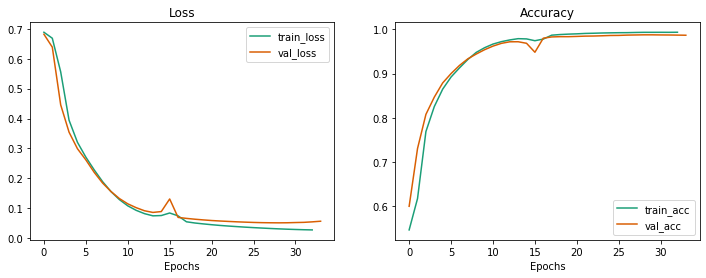

In [7]:
for key, gen in object_generators.items():
    print(key)
    """
    model = RelationNetModel(gen, 
    #                          embedding_size=8,
                             object_pair_layer_sizes=[32], # 32],
    #                          object_pair_layer_sizes=[256, 256, 256],
    #                          combined_object_layer_sizes=[256, 256],
                             combined_object_layer_sizes=[32],
                             # prediction_sizes=hidden_sizes, prediction_activation_class=nn.ReLU,
                             batch_size=2**10, lr=1e-3, 
                             train_epoch_size=2**14, validation_epoch_size=2**14,
    #                          train_epoch_size=2**10, validation_epoch_size=2**10,
                             regenerate_every_epoch=False)
    """
    
    """
    model = TransformerModel(gen, 
                             embedding_size=8,
                             mlp_sizes=[32],
                             batch_size=2**10, lr=1e-3, 
                             train_epoch_size=2**14, validation_epoch_size=2**14,
                             regenerate_every_epoch=False
                            )
    """
    train_dataset = ObjectGeneratorDataset(gen, 2 ** 14)
    validation_dataset = ObjectGeneratorDataset(gen, 2 ** 14)
    
    model = CNNModel(gen,
                     conv_sizes=[16, 16], conv_output_size=256,
                     batch_size=2**10, lr=1e-3, 
                     train_epoch_size=2**14, validation_epoch_size=2**14,
                     regenerate_every_epoch=False,
                     train_dataset=train_dataset, validation_dataset=validation_dataset
                    )
    
    use_gpu = int(torch.cuda.is_available())
    loggers = []
    loggers.append(PrintLogger())
    loggers.append(PlotLogger(dict(loss=('train_loss', 'val_loss'), accuracy=('train_acc', 'val_acc'))))
    trainer = Trainer(gpus=use_gpu, max_epochs=1000, logger=loggers,
                      early_stop_callback=EarlyStopping('val_loss', patience=5))
    trainer.fit(model)


In [18]:
gen = list(object_generators.items())[0][1]
train_dataset = ObjectGeneratorDataset(gen, 2 ** 7)
validation_dataset = ObjectGeneratorDataset(gen, 2 ** 7)

In [50]:
model = CNNModel(gen,
                 conv_sizes=[6, 6], conv_output_size=96,
                 mlp_sizes=[16, 16],
                 batch_size=2**10, lr=1e-3, 
#                  train_epoch_size=2**14, validation_epoch_size=2**14,
                 train_epoch_size=2**7, validation_epoch_size=2**7,
                 regenerate_every_epoch=False,
                 train_dataset=train_dataset, validation_dataset=validation_dataset
                )
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

2518


In [48]:
model = CNNModel(gen,
                 conv_sizes=[8, 12, 16], conv_output_size=64,
                 mlp_sizes=[32, 32, 32],
                 batch_size=2**10, lr=1e-3, 
#                  train_epoch_size=2**14, validation_epoch_size=2**14,
                 train_epoch_size=2**7, validation_epoch_size=2**7,
                 regenerate_every_epoch=False,
                 train_dataset=train_dataset, validation_dataset=validation_dataset
                )
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

7318


In [38]:
for p in model.parameters():
    print(p.name, p.numel())

None 432
None 8
None 576
None 8
None 576
None 8
None 4096
None 32
None 512
None 16
None 256
None 16
None 32
None 2


In [46]:
y = model.forward(model.train_dataset.objects)

RuntimeError: size mismatch, m1: [128 x 64], m2: [128 x 32] at /opt/conda/conda-bld/pytorch_1573049310284/work/aten/src/TH/generic/THTensorMath.cpp:197

In [ ]:
### N_OBJECTS = 4

for relation_class in (MultipleDAdjacentRelation, ColorAboveColorRelation, ObjectCountRelation):
    print(relation_class.__name__)
    gen = object_gen.SmartBalancedBatchObjectGenerator(N_OBJECTS, cfgs, relation_class,
                                                   object_dtype=torch.float, label_dtype=torch.long,
                                                   max_recursion_depth=100
                                                  )
    
    """
    model = RelationNetModel(gen, 
    #                          embedding_size=8,
                             object_pair_layer_sizes=[32], # 32],
    #                          object_pair_layer_sizes=[256, 256, 256],
    #                          combined_object_layer_sizes=[256, 256],
                             combined_object_layer_sizes=[32],
                             # prediction_sizes=hidden_sizes, prediction_activation_class=nn.ReLU,
                             batch_size=2**10, lr=1e-3, 
                             train_epoch_size=2**14, validation_epoch_size=2**14,
    #                          train_epoch_size=2**10, validation_epoch_size=2**10,
                             regenerate_every_epoch=False)
    """
    
    """
    model = TransformerModel(gen, 
                             embedding_size=8,
                             mlp_sizes=[32],
                             batch_size=2**10, lr=1e-3, 
                             train_epoch_size=2**14, validation_epoch_size=2**14,
                             regenerate_every_epoch=False
                            )
    """
    model = CNNModel(gen,
                     conv_output_size=16,
                     batch_size=2**10, lr=1e-3, 
                     train_epoch_size=2**14, validation_epoch_size=2**14,
                     regenerate_every_epoch=False
                    )
    
    use_gpu = int(torch.cuda.is_available())
    loggers = []
#     loggers.append(PrintLogger())
    loggers.append(PlotLogger(dict(loss=('train_loss', 'val_loss'), accuracy=('train_acc', 'val_acc'))))
    trainer = Trainer(gpus=use_gpu, max_epochs=1000, logger=loggers,
                      early_stop_callback=EarlyStopping('val_loss', patience=10))
    trainer.fit(model)


In [ ]:
assert(False)

In [ ]:
for train_size_power in (10, 12, 14, 16):
    model = RelationNetModel(gen, 
    #                          embedding_size=8,
                             object_pair_layer_sizes=[32], # 32],
    #                          object_pair_layer_sizes=[256, 256, 256],
    #                          combined_object_layer_sizes=[256, 256],
                             combined_object_layer_sizes=[32],
                             # prediction_sizes=hidden_sizes, prediction_activation_class=nn.ReLU,
                             batch_size=2**10, lr=1e-3, 
                             train_epoch_size=2**train_size_power, validation_epoch_size=2**14,
    #                          train_epoch_size=2**10, validation_epoch_size=2**10,
                             regenerate_every_epoch=False)
    
    use_gpu = int(torch.cuda.is_available())
    loggers = []
#     loggers.append(PrintLogger())
    loggers.append(PlotLogger(dict(loss=('train_loss', 'val_loss'), accuracy=('train_acc', 'val_acc'))))
    trainer = Trainer(gpus=use_gpu, max_epochs=1000, logger=loggers,
                      early_stop_callback=EarlyStopping('val_loss', patience=10))
    trainer.fit(model)

In [ ]:
use_gpu = int(torch.cuda.is_available())
loggers = []
loggers.append(PrintLogger())
loggers.append(PlotLogger(dict(loss=('train_loss', 'val_loss'), accuracy=('train_acc', 'val_acc'))))
trainer = Trainer(gpus=use_gpu, max_epochs=00, logger=loggers,
                  early_stop_callback=EarlyStopping('val_loss', patience=5))
trainer.fit(model)

In [ ]:
!git pull

In [ ]:
model

In [ ]:
N_OBJECTS = 8

gen = object_gen.SmartBalancedBatchObjectGenerator(N_OBJECTS, cfgs, MultipleDAdjacentRelation,
                                                   object_dtype=torch.float, label_dtype=torch.long,
                                                   max_recursion_depth=100
                                                  )
"""
model = RelationNetModel(gen, 
#                          embedding_size=8,
                         object_pair_layer_sizes=[32], # 32],
#                          object_pair_layer_sizes=[256, 256, 256],
#                          combined_object_layer_sizes=[256, 256],
                         combined_object_layer_sizes=[32],
                         # prediction_sizes=hidden_sizes, prediction_activation_class=nn.ReLU,
                         batch_size=2**10, lr=1e-3, 
                         train_epoch_size=2**14, validation_epoch_size=2**14,
#                          train_epoch_size=2**10, validation_epoch_size=2**10,
                         regenerate_every_epoch=False)
"""

"""
model = TransformerModel(gen, 
                         embedding_size=8,
                         mlp_sizes=[32],
                         batch_size=2**10, lr=1e-3, 
                         train_epoch_size=2**14, validation_epoch_size=2**14,
                         regenerate_every_epoch=False
                        )
"""
model = CNNModel(gen,
                 conv_sizes=[16, 32, 48], 
                 mlp_sizes=[64, 32, 16],
                 conv_output_size=192,
                 conv_stride=1,
                 batch_size=2**10, lr=1e-3, 
                 train_epoch_size=2**14, validation_epoch_size=2**14,
                 regenerate_every_epoch=False
                )

In [ ]:
model.cuda()
summary(model, (6, 16, 16))

In [ ]:
2 ** 16

In [ ]:
model.cuda()
summary(model, (6, 16, 16))